# Exploring and Preparing Loan Data

### Data Exploration

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import xgboost as xgb

In [2]:
# Import datasets
cr_loan = pd.read_csv('datasets/cr_loan2.csv')

In [3]:
# Check the structure of the data
print(cr_loan.dtypes)

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


In [4]:
# Check the first five rows of the data
print(cr_loan.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


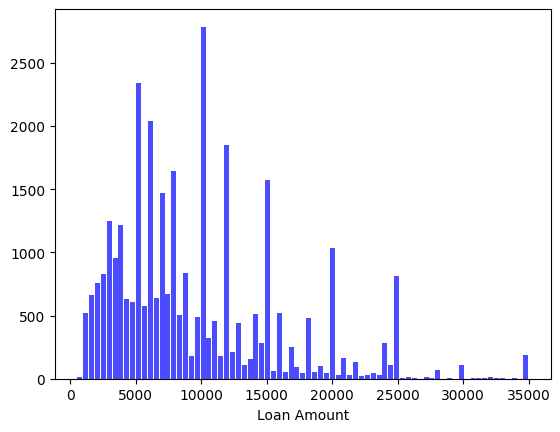

In [5]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

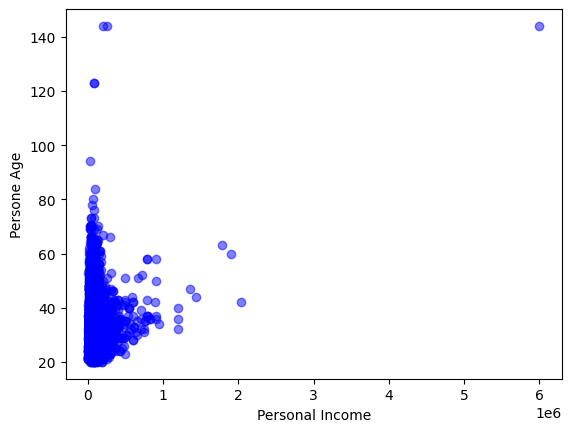

In [6]:
# Plot a scatter plot of income against age
plt.scatter(cr_loan['person_income'], cr_loan['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

### Crosstab and Pivot Tables

In [7]:
# Create a cross table of the loan intent and loan status
print(pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'], margins = True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581


In [8]:
# Create a cross table of home ownership, loan status, and grade
print(pd.crosstab(cr_loan['person_home_ownership'],[cr_loan['loan_status'],cr_loan['loan_grade']]))

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27  


In [9]:
# Create a cross table of home ownership, loan status, and average percent income
print(pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'], values=cr_loan['loan_percent_income'], aggfunc='mean'))

loan_status                   0         1
person_home_ownership                    
MORTGAGE               0.146504  0.184882
OTHER                  0.143784  0.300000
OWN                    0.180013  0.297358
RENT                   0.144611  0.264859


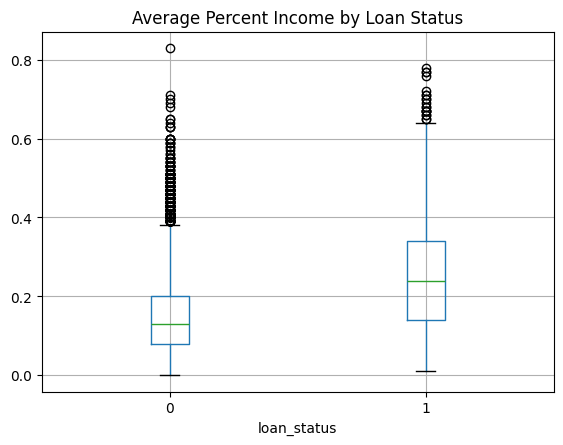

In [10]:
# Create a box plot of percentage income by loan status
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

## Outliers in credit data

In [11]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(cr_loan['loan_status'],cr_loan['person_home_ownership'],
                  values=cr_loan['person_emp_length'], aggfunc='max'))

# Create an array of indices where employment length is greater than 60
indices = cr_loan[cr_loan['person_emp_length'] > 60].index

# Drop the records from the data based on the indices and create a new dataframe
cr_loan_new = cr_loan.drop(indices)

# Create the cross table from earlier and include minimum employment length
print(pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max']))

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0
                           min                      max                  
person_home_ownership MORTGAGE OTHER  OWN RENT MORTGAGE OTHER   OWN  RENT
loan_status                                                              
0                          0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1                          0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0


### Visualizing Credit Outliers

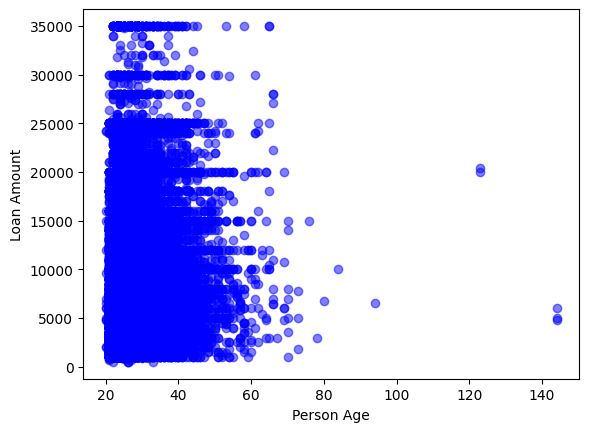

In [12]:
# Create the scatter plot for age and amount
plt.scatter(cr_loan['person_age'], cr_loan['loan_amnt'], c='blue', alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Amount")
plt.show()

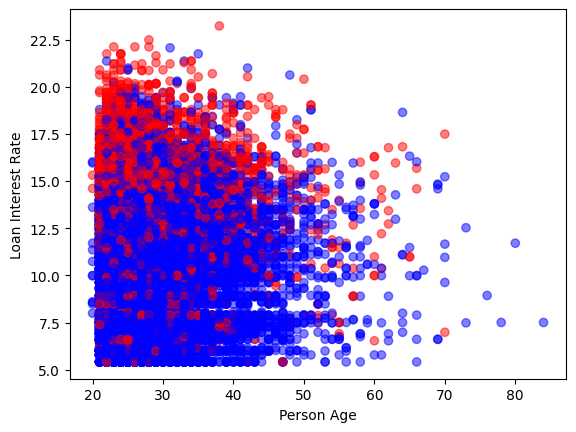

In [13]:
# Use Pandas to drop the record from the data frame and create a new one
cr_loan_new = cr_loan.drop(cr_loan[cr_loan['person_age'] > 100].index)

# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.scatter(cr_loan_new['person_age'], cr_loan_new['loan_int_rate'],
            c = cr_loan_new['loan_status'],
            cmap = ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

## Risk with missing data in loan data

### Handling Missing Credit Data

In [14]:
cr_loan = pd.read_csv("datasets/cr_loan_no_out.csv")

Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  person_income person_home_ownership  person_emp_length  \
103          22          12600              MORTGAGE                NaN   
218          24         185000              MORTGAGE                NaN   
375          24          16800              MORTGAGE                NaN   
403          25          52000                  RENT                NaN   
404          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
103           PERSONAL          A       2000           5.42            1   
218          EDUCATION          B      35000          12.42            0   
375  DEBTCONSOLIDATION          A       3900            NaN            1   
403           PERSONAL          B      24000          10.74            1   
404          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_pe

C:\Users\prach\AppData\Local\Temp\ipykernel_24108\3164706640.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)


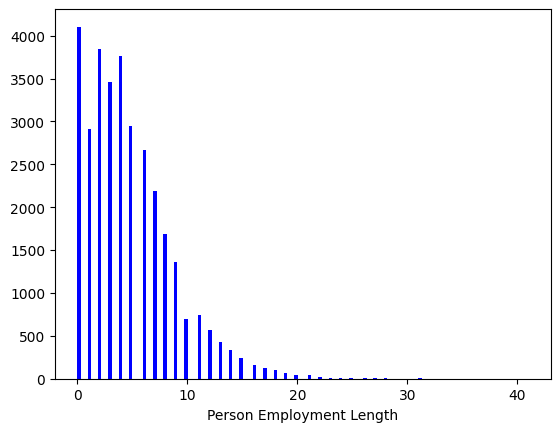

In [15]:
# Print a null value column array
print(cr_loan.columns[cr_loan.isnull().any()])

# Print the top five rows with nulls for employment length
print(cr_loan[cr_loan['person_emp_length'].isnull()].head())

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

### Removing Missing Data

In [16]:
# Print the number of nulls
print(cr_loan['loan_int_rate'].isnull().sum())

# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)
print(cr_loan_clean['loan_int_rate'].isnull().sum())

3115
0


### Handling Missing Data: Intuition Check

In [17]:
cr_loan = pd.read_csv("datasets/cr_loan_no_out_intuition.csv")

In [18]:
ownership_table = cr_loan['person_home_ownership'].value_counts(dropna = False)
print(ownership_table)

# Count the number of records for each unique value
print(cr_loan['person_home_ownership'].value_counts())

# Replace missing data with the value 'Other' because there is an all-inclusive class within 'person_home_ownership' that stores all other types of home ownership as 'Other'
cr_loan['person_home_ownership'].fillna('Other', inplace=True)

person_home_ownership
RENT        16441
MORTGAGE    13438
OWN          2583
OTHER         107
NaN             5
Name: count, dtype: int64
person_home_ownership
RENT        16441
MORTGAGE    13438
OWN          2583
OTHER         107
Name: count, dtype: int64


C:\Users\prach\AppData\Local\Temp\ipykernel_24108\567650364.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cr_loan['person_home_ownership'].fillna('Other', inplace=True)


# Logistic Regression for Defaults

## Logistic regression for probability of default

### Logistic Regression Basics

In [19]:
cr_loan_clean = pd.read_csv("datasets/cr_loan_nout_nmiss.csv")

In [20]:
# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate']]
y = cr_loan_clean[['loan_status']]

# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression(solver='lbfgs')
clf_logistic_single.fit(X, np.ravel(y))

# Print the parameters of the model
print(clf_logistic_single.get_params())

# Print the intercept of the model
print(clf_logistic_single.intercept_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[-4.45784525]


### Multivariate Logistic Regression

In [21]:
# Create X data for the model
X_multi = cr_loan_clean[['loan_int_rate','person_emp_length']]

# Create a set of y data for training
y = cr_loan_clean[['loan_status']]

# Create and train a new logistic regression
clf_logistic_multi = LogisticRegression(solver='lbfgs').fit(X_multi, np.ravel(y))

# Print the intercept of the model
print(clf_logistic_multi.intercept_)

[-4.21644963]


### Creating Training and Test Sets

In [22]:
# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate','person_emp_length','person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 2.88774130e-01 -2.19063447e-02 -1.99385087e-05]]


### Analyzing Coefficient Changes

In [23]:
X1 = cr_loan_clean[['person_income','person_emp_length','loan_amnt']]
X2 = cr_loan_clean[['person_income','loan_percent_income','cb_person_cred_hist_length']]

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=.4, random_state=123)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

# Print the first five rows of each training set
print(X1_train.head())
print(X2_train.head())

# Create and train a model on the first training data
clf_logistic1 = LogisticRegression(solver='lbfgs').fit(X1_train, np.ravel(y_train))

# Create and train a model on the second training data
clf_logistic2 = LogisticRegression(solver='lbfgs').fit(X2_train, np.ravel(y_train))

# Print the coefficients of each model
print(clf_logistic1.coef_)
print(clf_logistic2.coef_)

       person_income  person_emp_length  loan_amnt
22105          72000                  3       9000
2296           21000                  2       3000
14465           4800                  0       1200
6311           92000                  0       6000
12541          96000                  1       7000
       person_income  loan_percent_income  cb_person_cred_hist_length
22105          72000                 0.13                           6
2296           21000                 0.14                           2
14465           4800                 0.25                           2
6311           92000                 0.07                           3
12541          96000                 0.07                           4
[[-3.16705828e-05 -3.92650892e-02  1.15545651e-04]]
[[-1.00869026e-05  7.25248394e+00 -6.57472166e-04]]


### One-Hot Encoding Credit Data

In [24]:
# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(cr_loan_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

### Predicting Probability of Default

In [25]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Create dataframes of predictions, and true labels
preds_df_all = pd.DataFrame(preds[:,1], columns = ['prob_default'])
true_df_all = y_test

In [26]:
# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            1      0.386515
1            1      0.455655
2            0      0.072587
3            0      0.133768
4            1      0.147980


In [27]:
print(pd.concat([true_df_all.reset_index(drop = True), preds_df_all], axis = 1))

       loan_status  prob_default
0                1      0.386515
1                1      0.455655
2                0      0.072587
3                0      0.133768
4                1      0.147980
...            ...           ...
11779            0      0.042199
11780            0      0.144247
11781            0      0.252707
11782            0      0.359805
11783            0      0.225239

[11784 rows x 2 columns]


## Credit model performance

### Default Classification Reporting

In [28]:
cr_loan_prep = pd.read_csv("datasets/cr_loan_w2.csv")

In [29]:
X = cr_loan_prep.drop('loan_status', axis = 1)
y = cr_loan_prep['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_logistic = LogisticRegression(solver='lbfgs', max_iter=1000)
clf_logistic.fit(X_train_scaled, y_train)

preds = clf_logistic.predict_proba(X_test_scaled)

In [30]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
print(preds_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

loan_status
0    9845
1    1939
Name: count, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.89      0.95      0.92      9198
     Default       0.76      0.57      0.65      2586

    accuracy                           0.87     11784
   macro avg       0.83      0.76      0.79     11784
weighted avg       0.86      0.87      0.86     11784



### Selecting report metrics

In [31]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.89      0.95      0.92      9198
     Default       0.76      0.57      0.65      2586

    accuracy                           0.87     11784
   macro avg       0.83      0.76      0.79     11784
weighted avg       0.86      0.87      0.86     11784



In [32]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y_test,preds_df['loan_status']))

(array([0.88776028, 0.76379577]), array([0.95020657, 0.57269915]), array([0.9179226 , 0.65458564]), array([9198, 2586]))


In [33]:
# Print the first two numbers from the report
print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[0])

[0.88776028 0.76379577]


### Visually Scoring Credit Models

0.8673625254582484


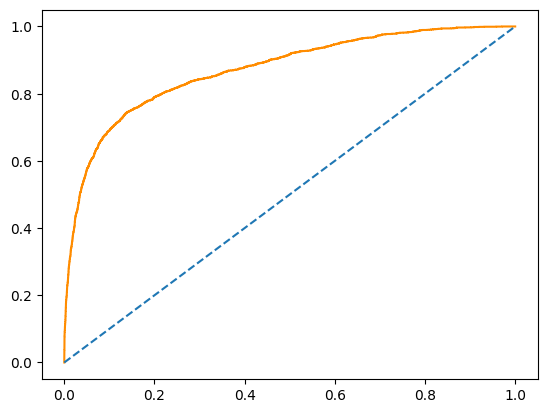

0.8708657872596467


In [34]:
# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test_scaled)

# Print the accuracy score the model
print(clf_logistic.score(X_test_scaled, y_test))

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(auc)

## Model discrimination and impact

### Thresholds and Confusion Matrices

In [35]:
# Set the threshold for defaults to 0.5
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test, preds_df['loan_status']))

print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1])

[[8740  458]
 [1105 1481]]
0.5726991492652745


In [36]:
# Set the threshold for defaults to 0.4
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test, preds_df['loan_status']))

print(precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1])

[[8481  717]
 [ 897 1689]]
0.6531322505800464


### How Thresholds Affect Performance

In [37]:
clf_logistic_preds = clf_logistic.predict_proba(X_test_scaled)
preds_df = pd.DataFrame(clf_logistic_preds[:,1], columns = ['prob_default'])
avg_loan_amnt = np.mean(cr_loan_prep['loan_amnt'])

In [38]:
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

7998126.464497551


### Threshold Selection

In [39]:
# Build Function
default_recalls = []
non_default_recalls = []
accuracies = []
ticks = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

# Thresholds
thresh = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

# Loop through each threshold
for t in thresh:
    # Apply threshold
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > t else 0)
    
    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test, preds_df['loan_status'])
    accuracy = accuracy_score(y_test, preds_df['loan_status'])
    
    # Append results to lists
    default_recalls.append(recall[1])
    non_default_recalls.append(recall[0])
    accuracies.append(accuracy)

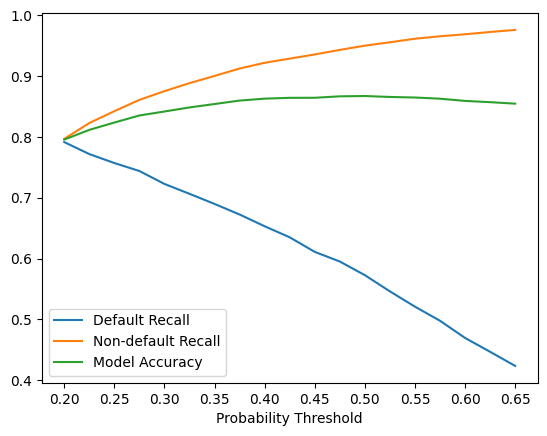

In [40]:
# Plot Graph
plt.plot(thresh,default_recalls)
plt.plot(thresh,non_default_recalls)
plt.plot(thresh,accuracies)
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

# Gradient Boosted Trees Using XGBoost

## Gradient boosted trees with XGBoost

In [41]:
cr_loan_prep = pd.read_csv("datasets/cr_loan_w2.csv")
X, y = cr_loan_prep.drop('loan_status', axis = 1), cr_loan_prep['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_logistic = LogisticRegression(solver='lbfgs', max_iter=1000)
clf_logistic.fit(X_train_scaled, y_train)

preds = clf_logistic.predict_proba(X_test_scaled)

### Trees for defaults

In [42]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            1      0.995308
1            1      0.974480
2            0      0.000392
3            0      0.001209
4            1      0.091886


### Gradient Boosted Portfolio Performance

In [43]:
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))
gbt_preds = pd.DataFrame(clf_gbt.predict_proba(X_test)[:,1][:], columns = ['gbt_prob_default'])
lr_preds = pd.DataFrame(clf_logistic.predict_proba(X_test_scaled)[:,1][:], columns = ['lr_prob_default'])
lgd = pd.DataFrame(np.full((len(y_test)), 0.20), columns = ['lgd'])

In [44]:
portfolio = pd.concat([gbt_preds, lr_preds, lgd,X_test[['loan_amnt']].reset_index(drop = True)], axis = 1)

In [45]:
# Print the first five rows of the portfolio data frame
print(portfolio.head())

   gbt_prob_default  lr_prob_default  lgd  loan_amnt
0          0.995308         0.646961  0.2      15000
1          0.974480         0.829529  0.2      11200
2          0.000392         0.085742  0.2      15000
3          0.001209         0.057660  0.2      10800
4          0.091886         0.044839  0.2       3000


In [46]:
# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

LR expected loss:  5676900.832415893
GBT expected loss:  5370881.076055614


### Assessing Gradient Boosted Trees


In [47]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)

[1 1 0 ... 0 0 0]


In [48]:
# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.73      0.82      2586

    accuracy                           0.93     11784
   macro avg       0.93      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



## Column selection for credit risk

### Column Importance and Default Prediction

In [49]:
X = cr_loan_prep[['person_income','loan_int_rate',
                  'loan_percent_income','loan_amnt',
                  'person_home_ownership_MORTGAGE','loan_grade_F']]
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [50]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'person_income': 1150.0, 'loan_int_rate': 1213.0, 'loan_percent_income': 671.0, 'loan_amnt': 632.0, 'person_home_ownership_MORTGAGE': 146.0, 'loan_grade_F': 16.0}


### Visualizing Column Importance

In [51]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]
y = cr_loan_prep[['loan_status']]
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.4, random_state=123)

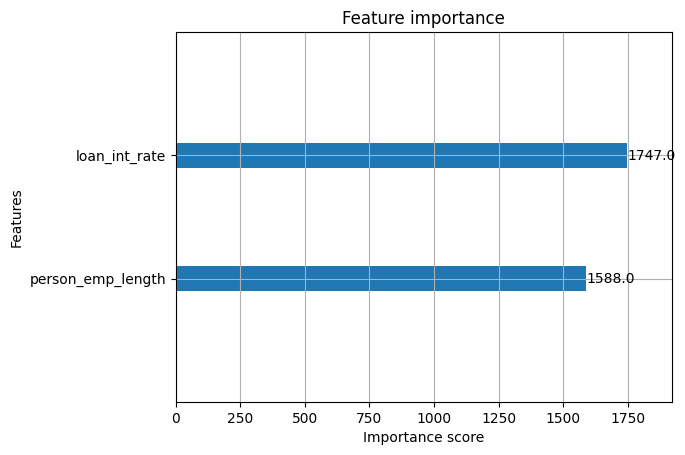

In [52]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

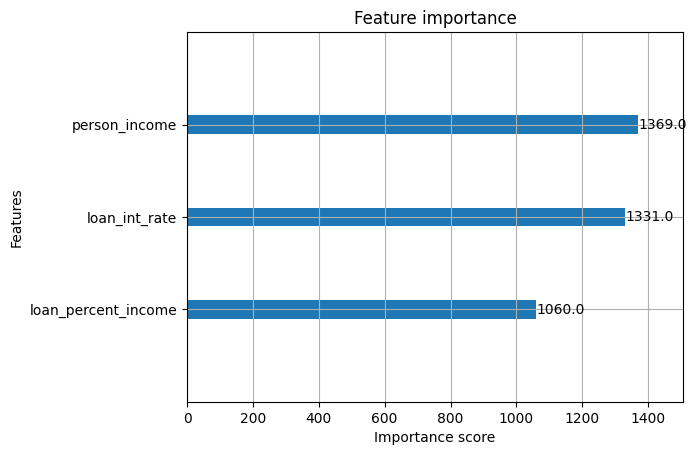

In [53]:
# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

### Column Selection and Model Performance

In [54]:
X = cr_loan_prep[['person_income', 'loan_int_rate', 'loan_percent_income', 'loan_amnt', 'person_home_ownership_MORTGAGE']]
X2 = cr_loan_prep[['person_income', 'loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership_RENT']]
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))
gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

In [55]:
# Predict the loan_status using each model
gbt_preds = gbt.predict(X_test)
gbt2_preds = gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.95      0.93      9198
     Default       0.78      0.65      0.71      2586

    accuracy                           0.88     11784
   macro avg       0.84      0.80      0.82     11784
weighted avg       0.88      0.88      0.88     11784

              precision    recall  f1-score   support

 Non-Default       0.91      0.97      0.94      9198
     Default       0.88      0.64      0.74      2586

    accuracy                           0.90     11784
   macro avg       0.89      0.81      0.84     11784
weighted avg       0.90      0.90      0.89     11784



## Cross validation for credit models

### Cross-Validating Credit Models

In [56]:
cr_loan_prep = pd.read_csv("datasets/cr_loan_w2.csv")
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}
X, y = cr_loan_prep.drop('loan_status', axis = 1), cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

In [57]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.900115       0.001252       0.895262      0.003995
1        0.909839       0.003303       0.904063      0.003418
2        0.917943       0.001963       0.910350      0.004863
3        0.922607       0.001285       0.914046      0.005164
4        0.926630       0.002077       0.917409      0.004201


### Limits to Cross-Validation Testing

In [58]:
cv_results_big = pd.read_csv("datasets/cv_results.csv")
cv_results_big = cv_results_big.drop('Unnamed: 0', axis=1)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.897568       0.000909       0.892900      0.008258
1        0.906985       0.002611       0.901162      0.007519
2        0.913678       0.001403       0.907910      0.007753
3        0.919123       0.000921       0.912130      0.007145
4        0.922864       0.001097       0.914962      0.006706
0.94


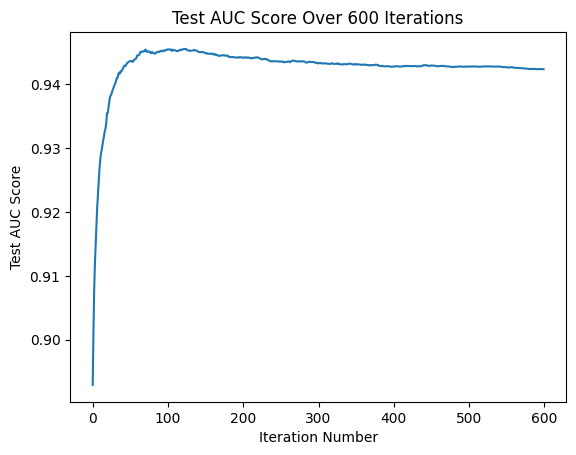

In [59]:
# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']).round(2))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

### Cross-Validation Scoring

In [60]:
# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

[0.93844761 0.93143245 0.93211134 0.9264373 ]
Average accuracy: 0.93 (+/- 0.01)


## Class imbalance in loan data

### Undersampling Training Data

In [61]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [62]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

loan_status
0    3877
1    3877
Name: count, dtype: int64


### Undersampled Tree Performance

In [63]:
# gbt
cr_loan_prep = pd.read_csv("datasets/cr_loan_w2.csv")
X, y = cr_loan_prep.drop('loan_status', axis = 1), cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 7).fit(X_train,np.ravel(y_train))
gbt_preds = gbt.predict(X_test)

# gbt2
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]
nondefaults_under = nondefaults.sample(count_default)
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True), defaults.reset_index(drop = True)], axis = 0)
X_train_under = X_y_train_under.drop(columns=['loan_status'])
y_train_under = X_y_train_under['loan_status']
gbt2 = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 7).fit(X_train_under, y_train_under)
gbt2_preds = gbt2.predict(X_test)

In [64]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.95      0.73      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784

              precision    recall  f1-score   support

 Non-Default       0.95      0.91      0.93      9198
     Default       0.72      0.82      0.77      2586

    accuracy                           0.89     11784
   macro avg       0.84      0.87      0.85     11784
weighted avg       0.90      0.89      0.89     11784



In [65]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test,gbt2_preds))

[[9107   91]
 [ 693 1893]]
[[8385  813]
 [ 463 2123]]


In [66]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test, gbt2_preds))

0.8610625531929922
0.8662851149422678


# Model Evaluation and Implementation

## Model evaluation and implementation

### Comparing Model Reports


In [67]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb

In [68]:
cr_loan_prep = pd.read_csv("datasets/cr_loan_w2.csv")
X = cr_loan_prep.drop('loan_status', axis = 1)
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# LogisticRegression
clf_logistic = LogisticRegression(solver='lbfgs', max_iter = 15, C = 1.0).fit(X_train, np.ravel(y_train))
clf_logistic_preds = clf_logistic.predict_proba(X_test)[:, 1]
preds_df_lr = pd.DataFrame(clf_logistic_preds, columns = ['prob_default'])
preds_df_lr['loan_status'] = preds_df_lr['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Gradient Boosted Trees (XGBoost)
clf_gbt = xgb.XGBClassifier(learning_rate=0.1, max_depth=7, min_split_loss=1.0, reg_lambda=1.2).fit(X_train, np.ravel(y_train))
clf_gbt_preds = pd.DataFrame(clf_gbt.predict_proba(X_test)[:, 1], columns = ['prob_default'])
preds_df_gbt = pd.DataFrame(clf_gbt_preds, columns = ['prob_default'])
preds_df_gbt['loan_status'] = preds_df_gbt['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

c:\Users\prach\OneDrive\Desktop\Learning\DataCamp\credit-risk-modeling\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 15 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=15).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test, preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test, preds_df_gbt['loan_status'], average = 'macro')[2])

              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9198
     Default       0.62      0.46      0.53      2586

    accuracy                           0.82     11784
   macro avg       0.74      0.69      0.71     11784
weighted avg       0.81      0.82      0.81     11784

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.95      0.73      0.82      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784

0.7109825732379738
0.8905137972684196


### Comparing with ROC Curves


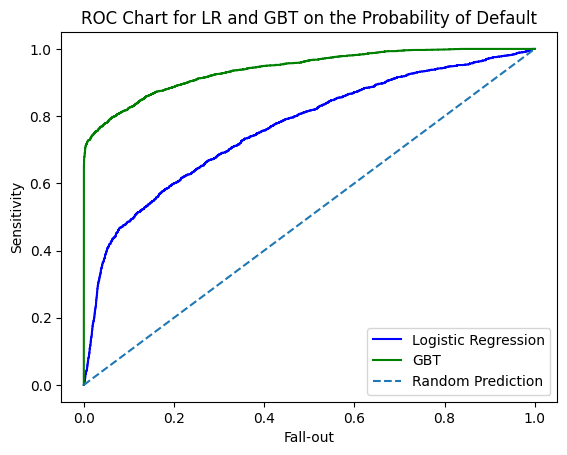

In [70]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, clf_logistic_preds)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt_preds)

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [71]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, clf_logistic_preds))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt_preds))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.94


### Calibration Curves


In [72]:
# Calculate calibration curve for logistic regression model
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, clf_logistic_preds, n_bins=16)

# Calculate calibration curve for gradient boosted tree model
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, clf_gbt_preds, n_bins=16)

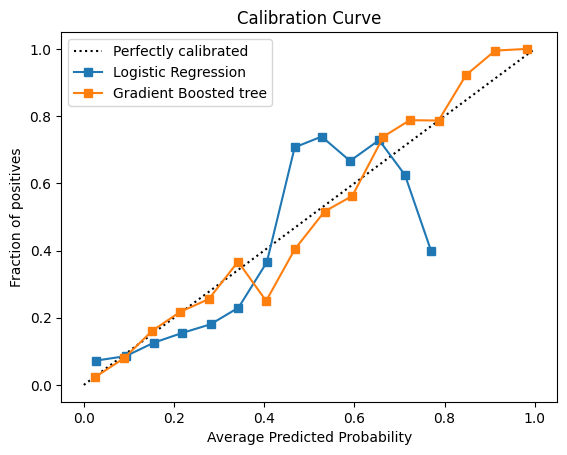

In [73]:
# Create the calibration curve plot with the guideline
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

# Add the calibration curve for the logistic regression to the plot
plt.plot(mean_pred_val_lr, frac_of_pos_lr, 's-', label='%s' % 'Logistic Regression')

# Add the calibration curve for the gradient boosted tree
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt, 's-', label='%s' % 'Gradient Boosted tree')

plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

## Credit acceptance rates

### Acceptance Rates


In [74]:
preds_list = clf_gbt_preds['prob_default'].tolist()
true_list = y_test['loan_status'].tolist()
lists = [true_list, preds_list]
test_pred_df = pd.concat([pd.Series(x) for x in lists], axis=1)
test_pred_df.columns = ['true_loan_status','prob_default']

In [75]:
# Check the statistics of the probabilities of default
print(test_pred_df['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.85)

# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
print(test_pred_df['pred_loan_status'].value_counts())

count    11784.000000
mean         0.218161
std          0.330048
min          0.000356
25%          0.025885
50%          0.070839
75%          0.180990
max          0.999084
Name: prob_default, dtype: float64
pred_loan_status
0    10016
1     1768
Name: count, dtype: int64


### Visualizing Quantiles of Acceptance


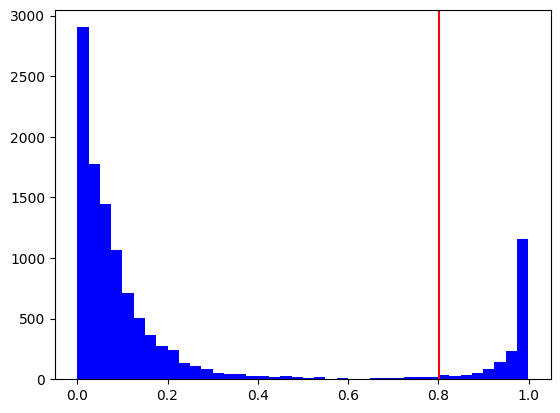

In [76]:
# Plot the predicted probabilities of default
plt.hist(clf_gbt_preds, color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(clf_gbt_preds, 0.85)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

### Bad Rates


In [77]:
# Print the top 5 rows of the new data frame
print(test_pred_df.head())

# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

   true_loan_status  prob_default  pred_loan_status
0                 1      0.984603                 1
1                 1      0.966659                 1
2                 0      0.002982                 0
3                 0      0.005300                 0
4                 1      0.068825                 0
0.08286741214057508


### Acceptance Rate Impact


In [78]:
preds_list = clf_gbt_preds['prob_default'].tolist()
true_list = y_test['loan_status'].tolist()
loan_amnt = X_test['loan_amnt'].tolist()
lists = [true_list, preds_list, loan_amnt]
test_pred_df = pd.concat([pd.Series(x) for x in lists], axis=1)
test_pred_df.columns = ['true_loan_status','prob_default','loan_amnt']

threshold_15 = np.quantile(preds_df_gbt['prob_default'], 0.85)
test_pred_df['pred_loan_status_15'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_15 else 0)

In [79]:
# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status_15']).apply(lambda x: x * avg_loan, axis = 0))

count    11784.000000
mean      9556.283944
std       6238.005674
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
pred_loan_status_15              0              1
true_loan_status                                 
0                   $87,784,024.31    $114,675.41
1                    $7,931,715.67 $16,780,834.61


In [80]:
# Reset format
pd.reset_option('display.float_format')

## Credit strategy and minimum expected loss

### Making the Strategy Table


In [81]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
thresholds = []
bad_rates = []

In [82]:
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))

In [83]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates), columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      0.999     0.219
1              0.95      0.989     0.174
2              0.90      0.972     0.133
3              0.85      0.801     0.083
4              0.80      0.250     0.063
5              0.75      0.181     0.054
6              0.70      0.141     0.044
7              0.65      0.116     0.038
8              0.60      0.097     0.032
9              0.55      0.083     0.028
10             0.50      0.071     0.024
11             0.45      0.060     0.023
12             0.40      0.051     0.019
13             0.35      0.042     0.015
14             0.30      0.034     0.012
15             0.25      0.026     0.006
16             0.20      0.017     0.003
17             0.15      0.009     0.002
18             0.10      0.004     0.000
19             0.05      0.003     0.000


### Visualizing the Strategy


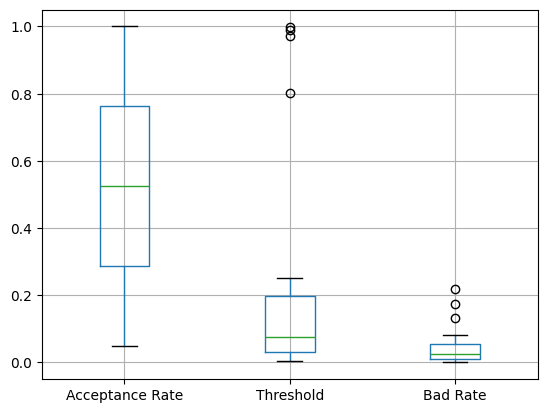

In [84]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()

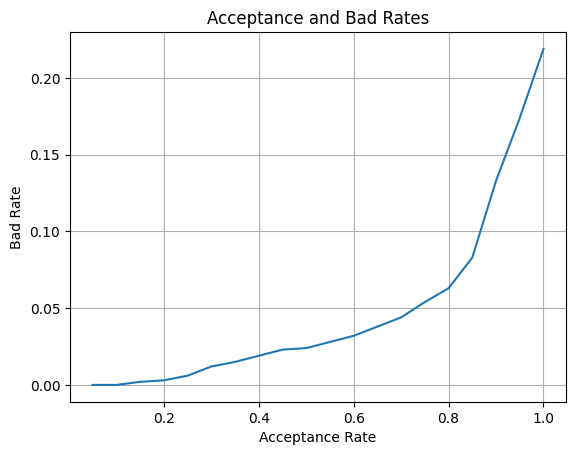

In [85]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(True)
plt.show()

### Estimated Value Profiling

In [86]:
# Print the contents of the strategy df
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      0.999     0.219
1              0.95      0.989     0.174
2              0.90      0.972     0.133
3              0.85      0.801     0.083
4              0.80      0.250     0.063
5              0.75      0.181     0.054
6              0.70      0.141     0.044
7              0.65      0.116     0.038
8              0.60      0.097     0.032
9              0.55      0.083     0.028
10             0.50      0.071     0.024
11             0.45      0.060     0.023
12             0.40      0.051     0.019
13             0.35      0.042     0.015
14             0.30      0.034     0.012
15             0.25      0.026     0.006
16             0.20      0.017     0.003
17             0.15      0.009     0.002
18             0.10      0.004     0.000
19             0.05      0.003     0.000


In [87]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
thresholds = []
bad_rates = []
num_accepted_loans = []
avg_loan_amnt = []

In [88]:
# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))
    # Calculate and append the number of accepted loans
    num_accepted_loans.append(len(test_pred_df[test_pred_df['prob_default'] < thresh]))
    # Calculate and append the average loan amount
    avg_loan_amnt.append(test_pred_df['loan_amnt'].mean().round(3))

In [89]:
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted_loans, avg_loan_amnt), 
                        columns = ['Acceptance Rate', 'Threshold', 'Bad Rate', 'Num Accepted Loans', 'Avg Loan Amnt'])

# Calculate the Estimated Value column
strat_df['Estimated Value'] = ((strat_df['Num Accepted Loans'] * (1 - strat_df['Bad Rate'])) * strat_df['Avg Loan Amnt']) - \
                              (strat_df['Num Accepted Loans'] * strat_df['Bad Rate'] * strat_df['Avg Loan Amnt'])

In [90]:
# Display the strategy DataFrame
strat_df

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
0,1.00,0.999,0.219,11783,9556.284,6.328215e+07
1,0.95,0.989,0.174,11140,9556.284,6.940997e+07
2,0.90,0.972,0.133,10603,9556.284,7.437275e+07
3,0.85,0.801,0.083,10016,9556.284,7.982693e+07
4,0.80,0.250,0.063,9425,9556.284,7.871941e+07
5,0.75,0.181,0.054,8838,9556.284,7.533693e+07
6,0.70,0.141,0.044,8247,9556.284,7.187533e+07
7,0.65,0.116,0.038,7669,9556.284,6.771732e+07
8,0.60,0.097,0.032,7077,9556.284,6.330151e+07
9,0.55,0.083,0.028,6474,9556.284,5.840281e+07


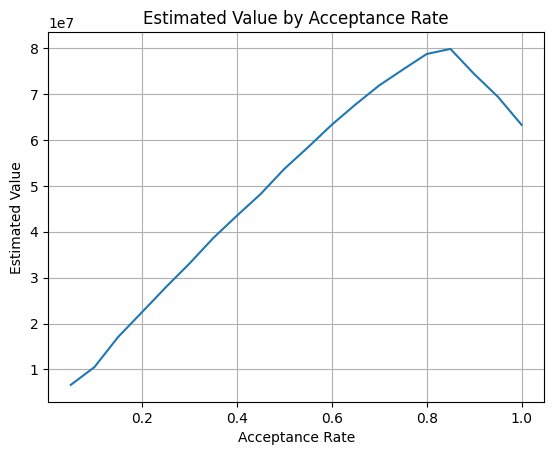

In [91]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(True)
plt.show()

In [92]:
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

   Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
3             0.85      0.801     0.083               10016       9556.284   

   Estimated Value  
3     7.982693e+07  


### Total Expected Loss


In [93]:
# Print the first five rows of the data frame
print(test_pred_df.head())

# Assume the loss given default is 100%
test_pred_df['loss_given_default'] = 1.0

# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * test_pred_df['loss_given_default']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   true_loan_status  prob_default  loan_amnt  pred_loan_status_15  \
0                 1      0.984603      15000                    1   
1                 1      0.966659      11200                    1   
2                 0      0.002982      15000                    0   
3                 0      0.005300      10800                    0   
4                 1      0.068825       3000                    0   

   pred_loan_status  
0                 1  
1                 1  
2                 0  
3                 1  
4                 1  
Total expected loss:  $27,217,205.06
